In [1]:
'''
Date: 2023/Jan/1
Author: Yike Xie
Content: Create the fluorescent matrix of FAD according to existing publications
'''

'\nDate: 2023/Jan/1\nAuthor: Yike Xie\nContent: Create the fluorescent matrix of FAD according to existing publications\n'

In [2]:
# paper: https://www.atlantis-press.com/proceedings/icadme-15/25840124#:~:text=Two%20strong%20fluorescence%20peaks%20of,%3D260%2F280nm%20were%20found.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL
import seaborn as sns

In [4]:
wls =np.array([
 (325, 414),
 (343, 414),#
 (370, 414),
 (343, 451),
 (370, 451),
 (373, 451),
 (343, 575),#
 (393, 575),
 (406, 575),
 (441, 575),
 (400, 594),
 (406, 594),
 (431, 594),
 (480, 594),#
 (339, 575),
])

In [5]:
def load_figure(fmt_fn, fmt_fn1):
    rgba_image = PIL.Image.open(fmt_fn)
    rgb_image = rgba_image.convert('RGB')
    rgb_image.save(fmt_fn1)

    # load as a RGB image
    fmt = plt.imread(fmt_fn1)
    fmt *= 255
    fmt = fmt.astype(int)

    plt.imshow(fmt)
    plt.axis('off')
    
    return fmt

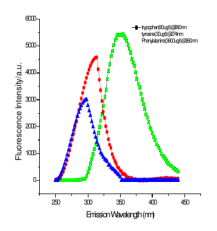

In [6]:
fmt_fn = '/home/yike/phd/cancer_cells_img_seq/scripts/spetra_matrixs/ems2.png'
fmt_fn1 = '/home/yike/phd/cancer_cells_img_seq/scripts/spetra_matrixs/ems3.png'
fmt_ems = load_figure(fmt_fn, fmt_fn1)

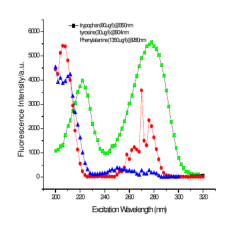

In [7]:
fmt_fn = '/home/yike/phd/cancer_cells_img_seq/scripts/spetra_matrixs/exs2.png'
fmt_fn1 = '/home/yike/phd/cancer_cells_img_seq/scripts/spetra_matrixs/exs3.png'
fmt_exs = load_figure(fmt_fn, fmt_fn1)

In [8]:
def get_array(fmt):
    w = fmt.shape[1]
    l = fmt.shape[0]
    
    R = ((fmt[:, :, 0] > 180) & (fmt[:, :, 1] < 50) & (fmt[:, :, 2] < 50)) # red
    G = ((fmt[:, :, 0] < 50) & (fmt[:, :, 1] > 180) & (fmt[:, :, 2] < 50)) # green
    B = ((fmt[:, :, 0] < 50) & (fmt[:, :, 1] < 50) & (fmt[:, :, 2] > 180)) # blue
    K = ((fmt[:, :, 0] < 50) & (fmt[:, :, 1] < 50) & (fmt[:, :, 2] <50))

    # center
    cx = pd.Series(fmt[:, :, :].sum(axis=2).sum(axis=0), index=range(w)).sort_values().index[0] # x axis 70
    cy = pd.Series(fmt[:, :, :].sum(axis=2).sum(axis=1), index=range(l)).sort_values().index[0] # y axis 214

    # x axis, max
    x = pd.Series(fmt[:, :, :].sum(axis=2)[cy, :], index=range(w))
    # xmin = x[x < 100].index[0]
    xmax = x[x < 150].index[-1]

    # axis, min
    y = pd.Series(fmt[:, :, :].sum(axis=2)[:, cx], index=range(l))
    ymin = y[y < 100].index[0]  # upper
    # ymax = y[y < 100].index[-1] # lower
    
    fig, axs = plt.subplots(3, 2, figsize=[10, 9])
    axs[0, 0].imshow(R)
    axs[0, 1].imshow(G)
    axs[1, 0].imshow(B) 
    axs[1, 1].imshow(K)
    axs[2, 0].imshow(K)

    axs[2, 0].imshow(K)
    axs[2, 0].scatter(cx, cy, c='red', s=10)
    axs[2, 0].scatter(cx, ymin, c='red', s=10)
    axs[2, 0].scatter(xmax, cy, c='red', s=10)
    
    return {'R': R, 'G': G, 'B': B, 'K': K, 'cx': cx, 'xmax': xmax, 'cy': cy, 'ymin': ymin}

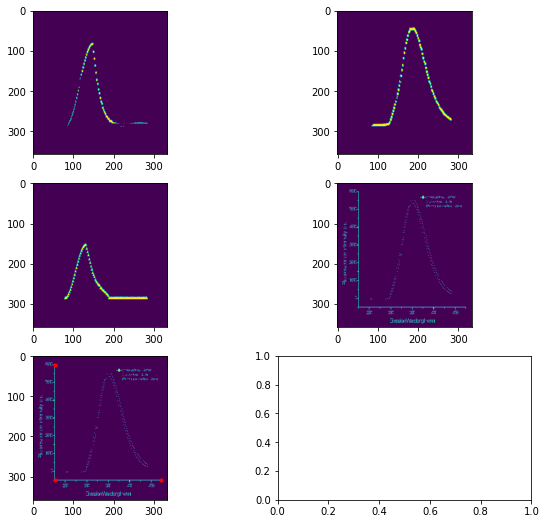

In [9]:
ems_dic = get_array(fmt_ems)

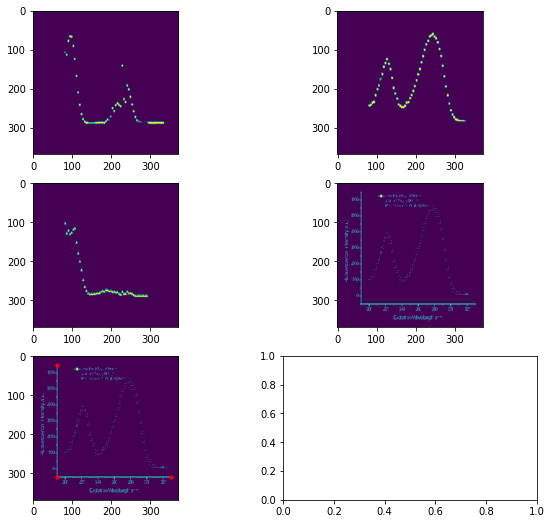

In [10]:
exs_dic = get_array(fmt_exs)

In [14]:
def get_ratio(ems_dic, C, imin, imax, wmin, wmax):
    C, K, cx, xmax, cy, ymin= ems_dic[C], ems_dic['K'], ems_dic['cx'], ems_dic['xmax'], ems_dic['cy'], ems_dic['ymin']
    ems = np.argwhere(C) # [y, x] [:, 1] x, [:, 0] y
    
    # emission wavelengths and fluorescent intensity
    em_its = {(x - cx) * (wmax - wmin) / (xmax - cx) + wmin : imax * (cy - y) / (cy - ymin)  for y, x  in ems}
    
    fig, axs = plt.subplots(2, figsize=(4, 3))
    axs[0].imshow(K)
    axs[0].scatter(ems[:, 1], ems[:, 0], color='red', s=5)

    axs[1].set_xlim(wmin, wmax)
    axs[1].set_ylim(imin, imax)
    axs[1].scatter(em_its.keys(), em_its.values(), color='red', s=5)
    axs[1].set_xlabel('Wavelengths (nm)')
    axs[1].set_ylabel('Fluorescent intensity')
    
    # emission wavelengths and fluorescent ratio
    em_it_max = max(em_its.values())
    import math
    em_ratio = {round(k, 1): v / em_it_max for k, v in em_its.items()}
    
    return em_ratio

def matrix(ex_ratio, em_ratio, name):
    # create the matrix and plot
    columns = list(ex_ratio.keys())
    columns.sort()
    index = list(em_ratio.keys())
    index.sort()
    index = index[::-1]

    df = pd.DataFrame(np.zeros(shape=(len(index), len(columns))), 
                          index=index, columns=columns)

    for x in ex_ratio.keys():
        for y in em_ratio.keys():
            df.at[y, x] = ex_ratio[x] * em_ratio[y]
    
    fdn = '/home/yike/phd/cancer_cells_img_seq/scripts/spetra_matrixs/heatmap/'
    df.to_csv(fdn + name + '_FL_ratio_matrix.tsv', sep='\t')

    fig, ax = plt.subplots(figsize=(4, 3))
    sns.heatmap(df, cmap='viridis', ax=ax)
    ax.set_xlabel('Excitation Wavelength (nm)')
    ax.set_ylabel('Emission Wavelength (nm)')
    ax.set_title(name)

    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    xmin, xmax = df.columns.min(), df.columns.max()
    ymin, ymax = df.index.min(), df.index.max()
    sx = [(i - xmin) * (xlim[1] - xlim[0]) / (xmax - xmin) + xlim[0] for i in wls[:, 0].tolist()]
    sy = [(i - ymin) * (ylim[1] - ylim[0]) / (ymax - ymin) + ylim[0] for i in wls[:, 1].tolist()]
    
    colors = sns.color_palette('hls', 15)
    handles, labels = ax.get_legend_handles_labels()
    for i, txt in enumerate(range(1, 16)):
        ax.scatter(sx[i], sy[i], color=colors[i], s=50)
        handles.append(ax.scatter([], [], color=colors[i], s=50)) 
    
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.legend(handles=handles, labels = [str(i) for i in wls], bbox_to_anchor=(1.45, 1))
    plt.savefig(fdn + name + '.png', dpi=300, bbox_inches='tight')
    
    return df

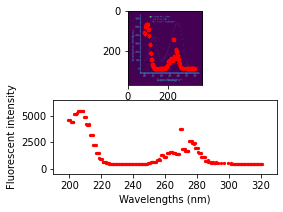

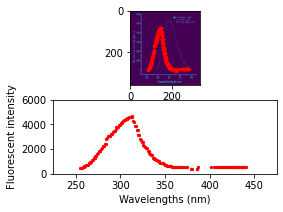

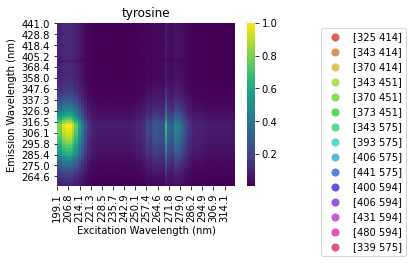

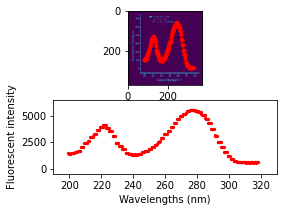

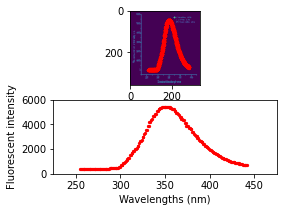

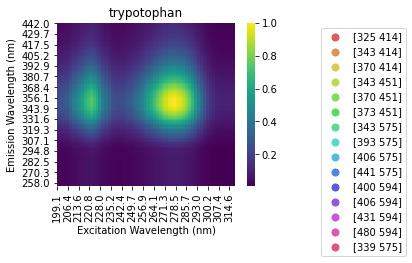

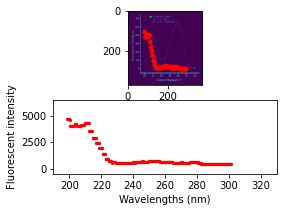

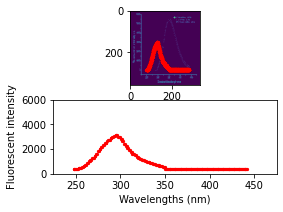

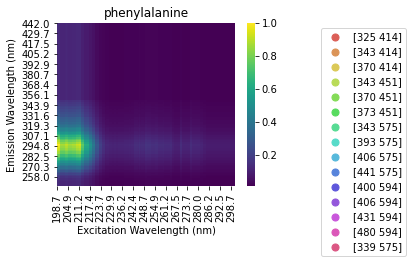

In [82]:
for C, name in zip(['R', 'G', 'B'], ['tyrosine', 'trypotophan', 'phenylalanine']):
    ex_ratio = get_ratio(exs_dic, C, -500, 6500, 190, 330)
    em_ratio = get_ratio(ems_dic, C, 0, 6000, 225, 475)
    matrix(ex_ratio, em_ratio, name)